# California Test Score Analysis

### Principal Component Analysis and Multivariate Regression

Hello and welcome! I am going to do a very basic, high level overview of the process to perform Principal Component Analysis (PCA) and Multivariate Regression on a dataset without dwelling too much on the technical details. I will first be using the statsmodels library to perform both, as its regression calculates statistics traditionally used to evaluate how well the model performs, whereas scikit-learn does not. Once the model is verified in statsmodels, we can see how the process looks in scikit-learn.

The dataset I'm using for this notebook was found on this site: https://rdrr.io/rforge/Ecdat/man/Caschool.html It lists the test scores per county and school district in California along with various attributes of those districts. The data is very old, collected in the late 90s - so it would potentially be possible to hunt down the data for later years and evaluate how well this model does on new data, however I am primarily using this dataset to get my feet wet working with these concepts in Python - more interesting datasets and analyses are forthcoming. (Also, introducing new data would introduce the time series factor, which complicates the analysis). 

With that all said, let's dive in! I'll explain things as we go along. So the first thing to do of course is to import the brilliant pandas library, which makes data manipulation trivial in Python. Then we want to read in our dataset (which I have pre-shuffled for a reason I'll explain later) into a data frame and look at a sample of the data to get a feel for what it's like. 

In [1]:
import pandas as pd

df = pd.read_csv('http://briannadardin.com/California_Test_Scores_Shuffled.csv')

df.head()

,Unnamed: 0,distcod,county,district,grspan,enrltot,teachers,calwpct,mealpct,computer,testscr,compstu,expnstu,str,avginc,elpct,readscr,mathscr
0,72,66886,Placer,Placer Hills Union Elementary,KK-08,1452,70.500000,2.426000,10.414200,183,671.900024,0.126033,5028.561523,20.595745,17.656000,0.000000,679.599976,664.200012
1,278,65680,Merced,El Nido Elementary,KK-08,184,9.000000,22.282600,85.869598,40,628.400024,0.217391,5090.044922,20.444445,8.178000,45.108696,621.599976,635.200012
2,144,65961,Monterey,Alisal Union Elementary,KK-06,7306,319.799988,17.001499,88.034897,742,623.200012,0.101560,4997.871582,22.845530,7.983181,73.720230,620.400024,626.000000
3,138,72470,Ventura,Mesa Union Elementary,KK-08,516,21.500000,0.969000,27.713200,50,676.849976,0.096899,4392.679688,24.000000,23.733000,11.046512,680.500000,673.200012
4,303,62513,Fresno,Washington Colony Elementary,KK-08,443,24.000000,14.221200,69.977402,52,644.500000,0.117381,5085.406250,18.458334,7.385000,21.444695,644.299988,644.700012


Most of the data consists of continuous variables, which is good news for our purposes - PCA only works with numeric variables. The categorical variables, the district code, county, district and grade span, could potentially be encoded to work with a model, but those variables could not be used for PCA. With other datasets, it would be common to have a mix of categorical dummy variables and principal components, but including district and county would greatly increase the dimensionality of our model for dubious benefit. Grade span can easily be encoded into a single binary variable however, so we will extract it from our dataset and leave it aside until we're ready to run the regression.

In [2]:
grade_span = pd.get_dummies(df['grspan'],drop_first=True)

Another thing to note is that the test score variable, testscr, is actually just the average of the reading score (readscr) and math score (mathscr). Regression only supports one target variable, so we will focus on the average test score and discard the separate reading and math scores. Now we can remove all these columns from our data frame:

In [3]:
df = df.iloc[:,5:-2]

df.head()

,enrltot,teachers,calwpct,mealpct,computer,testscr,compstu,expnstu,str,avginc,elpct
0,1452,70.500000,2.426000,10.414200,183,671.900024,0.126033,5028.561523,20.595745,17.656000,0.000000
1,184,9.000000,22.282600,85.869598,40,628.400024,0.217391,5090.044922,20.444445,8.178000,45.108696
2,7306,319.799988,17.001499,88.034897,742,623.200012,0.101560,4997.871582,22.845530,7.983181,73.720230
3,516,21.500000,0.969000,27.713200,50,676.849976,0.096899,4392.679688,24.000000,23.733000,11.046512
4,443,24.000000,14.221200,69.977402,52,644.500000,0.117381,5085.406250,18.458334,7.385000,21.444695


Now we are left with 10 independent variables and 1 dependent variable. In the age of big data, 10 columns is nothing, however we always want to try to simplify our models as much as possible, so we will attempt to reduce the dimensionality before proceeding with building the model.

First though, let's make sure our data doesn't have any missing values, as these algorithms won't work with them:

In [4]:
print(df.isnull().sum())

enrltot     0
teachers    0
calwpct     0
mealpct     0
computer    0
testscr     0
compstu     0
expnstu     0
str         0
avginc      0
elpct       0
dtype: int64


We got lucky with this dataset! Normally there are some missing values - I suspect this data was cleaned beforehand. Now we can keep going. The first thing we'll do with this is look at the relationship of each of our variables with our target variable, the test score, by drawing scatter plots with each. This way we can visually see what kind of relationships exist in our data.

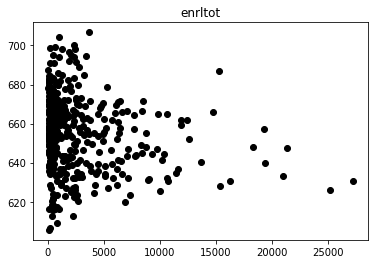

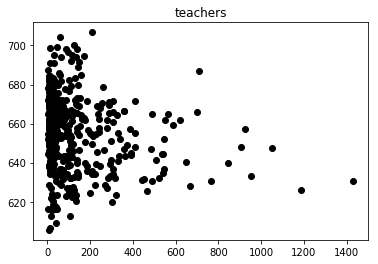

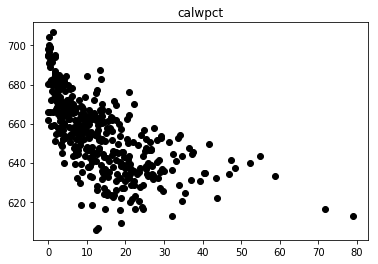

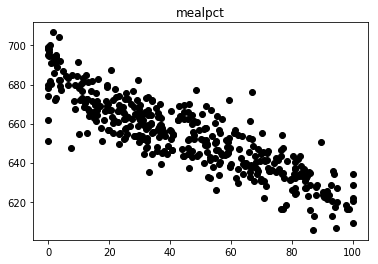

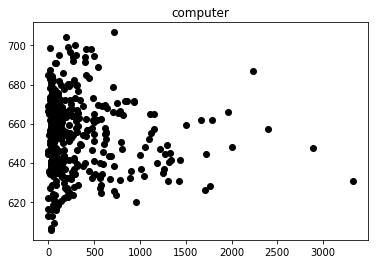

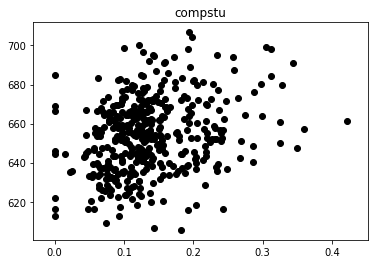

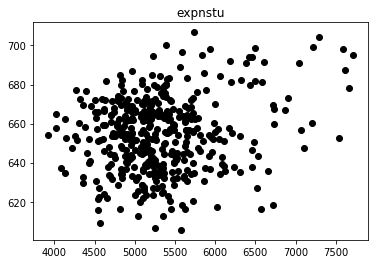

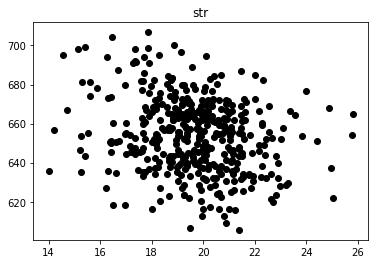

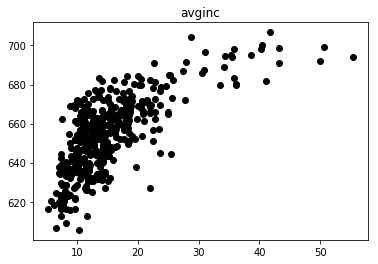

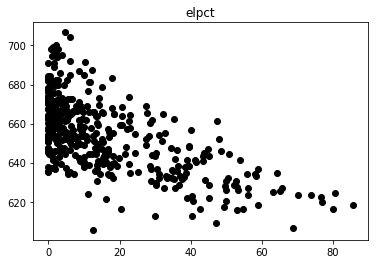

In [6]:
import matplotlib.pyplot as plt

for col in df.columns:
    if col == "testscr":
        continue
    plt.scatter(df[col],df["testscr"],color='black')
    plt.title(col)
    plt.show()

It turns out that most of our variables have little to no relationship with our target variable at all, which you can tell by the overall shape. Variables like compstu are just scattered everywhere with no discernible pattern at all. Three of the variables, enrltot, teachers, and computers share the same shape, suggesting correlations between those, but said shape doesn't bode well for their relationship with the test scores. The strong vertical pattern at the lower ends of those values means test scores fall within almost the entire range possible within them, so attempting to predict a score on the basis of those variables alone is a shot in the dark basically.

Thankfully, there are a few variables here that do appear to have some kind of relationship with our target. The percentage of students who qualify for CalWorks, or calwpct, has a slightly downward curving trend which resembles a negative square root curve. The percentange of students qualifying for cheaper lunches (mealpct) on the otherhand has a very strong and clear linear relationship with our target. Average income (avginc) appears to have a logarithmic relationship, though the higher values are rather sparse. Finally the percentage of students who speak English as a second language (elpct) seems to have a somewhat linear relationship, despite it also suffering from the vertical data problem mentioned previously, though to a lesser degree.

Based on this analysis of the scatter plots, I believe we can modify our hypothesis, and include only the 4 variables that we see have a relationship with the target (as well as our categorical variable, the grade span), as the others will likely provide minimal benefit to the model. If the model ends up not performing well, we would go back and re-evaluate the other variables. 

Before we proceed, we now need to also separate our target variable from the rest of the variables, so we can split the data into training and test subsets, and also to later perform PCA on those variables without affecting the target. This is also a good time to transform our average income variable by using the natural logarithm of the column, and the CalWorks percentage variable by taking its negative square root.

In [7]:
Y = df['testscr']
X = df.drop(['testscr','enrltot','teachers','computer','compstu','expnstu','str'],axis=1)

import numpy as np

X['avginc'] = X['avginc'].apply(lambda x: np.log(x))
X['calwpct'] = X['calwpct'].apply(lambda x: -np.sqrt(x))

Now you might be thinking we've already reduced our dataset to 5 variables. Is a dimension reduction technique like PCA really necessary here? It would depend on the use case, but generally, the fewer variables, the simpler the model, and the simpler, the better. So we will go ahead with PCA and see if we can reduce the number of variables even further.

However, there is an important thing to consider when doing PCA. It works best when all the variables have a similar or the same scale, as different scales will cause issues. The scales with these variables we've chosen aren't too drastically different, but if we had kept the expenditure variable for example, we would've ran into problems as those values are in the thousands while the others are in the tens or less, which would've given that variable a much higher weight with no good reason. 

In order to prevent this issue, we standardize, or normalize, our data. This essentially means subtracting the mean of the column from each value in the column, and dividing it by the standard deviation of the column. All of the data will then be in a similar range after doing this. While statsmodels's PCA has built in functions that do this for you when you run it, scikit-learn's does not. Also we will have to apply the standardization to both the training and test data for the model to work. Therefore it makes more sense to apply the standardization before splitting the data up, and use those sets for both statsmodels and scikit-learn. Scikit-learn has nice modules for standardization and splitting datasets, so I will use those here. Note I am setting shuffle to false so that the results are consistent every time this notebook is run - this is why I decided to pre-shuffle the dataset before loading it.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X),columns=X.columns.values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle=False)

Only now are we finally ready to apply PCA! Now I will try to give a general idea of what PCA does. It is very heavily based in linear algebra, and I will be assuming you have some familiarity with the concepts of vectors and matrices at least as explaining linear algebra is beyond the scope of this notebook. Now picture the dataset as a matrix, and each row of data is a vector and each column is a dimension that the vector exists in. What PCA does is find what's called the eigenvectors (and corresponding eigenvalues) of this matrix/dataset. Basically you're looking to find which directions in "space" have the most information, or the most variance. These directions are eigenvectors, and the eigenvalues tell you how much variance that vector explains. This enables us to create new variables based on these eigenvectors, and remove the ones that have low variance, thus reducing dimensionality. That's a super basic explanation - there are much better ones elsewhere (I recommend this one as it's fairly layman friendly; https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/), but the takeaway is that we're looking for where the most information in the dataset is so we can keep only the variables that give us information and discard the rest.

As mentioned earlier, I will be starting with statsmodels. The method call is straightforward, however since we pre-standardized our data, we need to make sure to set certain arguments as false, as they default to true (and can seriously mess up the results if left true).

In [9]:
from statsmodels.multivariate.pca import PCA as PCA_sm

pca = PCA_sm(X_train, standardize=False, demean=False, normalize=False)

Great, we have our PCA now! ...so now what? Well, the number of principal components generated match the number of columns in our dataset, in this case 4, and they've been automatically sorted in order of most variance explained to least variance explained. We can go ahead and take a look at the weights applied to each column (extracted from the eigenvectors, or the directions of most variance in the data)...

In [10]:
print(pca.loadings)

           comp_0    comp_1    comp_2    comp_3
calwpct -0.520162  0.378738  0.631561 -0.432574
mealpct  0.565431  0.054320 -0.124130 -0.813590
avginc  -0.508661  0.331778 -0.764925 -0.214654
elpct    0.388566  0.862282  0.024739  0.323843


However, this doesn't really tell us too much by itself! There are patterns here to notice - the variables we transformed, calwpct and avginc, are treated similarly in the first 3 components compared to the other 2 variables. Just for fun, let's see how our standardized, transformed data compares to these new variables we created.

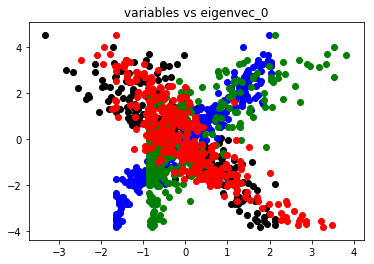

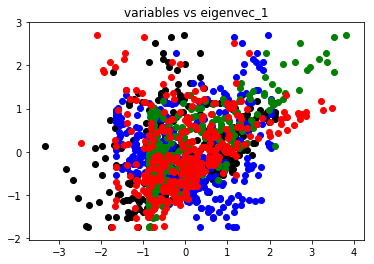

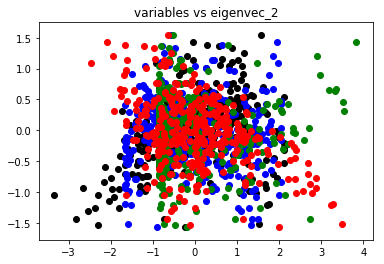

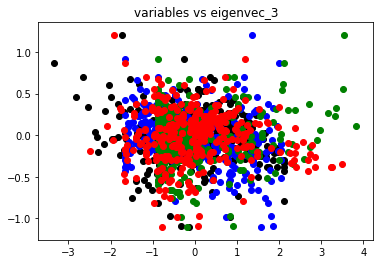

In [11]:
for i, e in enumerate(pca.eigenvecs.columns):
    plt.scatter(X_train['calwpct'],pca.scores['comp_'+str(i)],color='black')
    plt.scatter(X_train['mealpct'],pca.scores['comp_'+str(i)],color='blue')
    plt.scatter(X_train['elpct'],pca.scores['comp_'+str(i)],color='green')
    plt.scatter(X_train['avginc'],pca.scores['comp_'+str(i)],color='red')
    plt.title("variables vs "+e)
    plt.show()

Wow, look at the graph for the first eigenvector! We can see very clear directions the data goes in, which suggests this eigenvector likely has a pretty high eigenvalue. The other graphs look more like blobs, but since all the data is overlapping, there is at least some information being captured in these eigenvectors as well.

Now, the goal of PCA is to select the eigenvectors that explain the most variance, and discard the rest. They have already been ordered from greatest to least, but we don't know exactly how much each contributes to the variance (though the graphs give us a good idea). This is where we would look at the ratios of explained variance (aka eigenvalue) for each eigenvector, as well as the cumulative ratio when ordered from greatest to least. Now scikit-learn has a method that will do this calculation for you, but statsmodels does not, but thankfully it's a very easy thing to calculate, like so:

In [12]:
ratios = dict()
for i, val in enumerate(pca.eigenvals):
    ratio = val / np.sum(pca.eigenvals)
    if(i == 0):
        prev = 0
    else:
        prev = ratios['eigenvec_'+str(i-1)][1]
    ratios['eigenvec_'+str(i)] = [ratio, prev + ratio]

for r in ratios:
    print(r, ': Explained = ', ratios[r][0], ', Cumulative = ', ratios[r][1])

eigenvec_0 : Explained =  0.7202381368335965 , Cumulative =  0.7202381368335965
eigenvec_1 : Explained =  0.17889760299106766 , Cumulative =  0.8991357398246642
eigenvec_2 : Explained =  0.07648856036935138 , Cumulative =  0.9756243001940156
eigenvec_3 : Explained =  0.02437569980598455 , Cumulative =  1.0000000000000002


Two of our eigenvectors account for 90% of the variance in our data! We can literally go down from 4 variables to 2, or drop half the variables, and only lose 10% of information. That's pretty good. Now deciding how many of the variables to keep usually depends on the context and goal of the analysis. In this case, the first 2 variables encode enough information for us to test a model, and being able to cut the number of variables in half means that conducting the PCA was a worthy exercise after all.

Now we need to construct our training and test datasets. Remember our categorical variable, the grade span? We're now ready to add it back into the mix.

In [13]:
X_train_new = pd.concat([pca.scores.iloc[:,0:2], grade_span.iloc[X_train.index]], axis=1)

Now that we have our new training set comprised of our principal components (and grade span), we also have to transform our test dataset to have the same variables. Statsmodels doesn't have a built in method to do this, but thankfully it's pretty straightforward - it is simply a linear transformation of the dataset matrix performed by applying the eigenvector matrix, or in order words multiplying the matrices. So we can go ahead and create our test data by transforming it, keeping only the first 2 variables, then joining it with the grade span.

In [14]:
X_test_new = pd.DataFrame(np.dot(X_test, pca.eigenvecs), index=X_test.index).add_prefix('comp_').iloc[:,0:2]
X_test_new = pd.concat([X_test_new, grade_span.iloc[X_test_new.index]], axis=1)

Now that we have our new variables, we can finally move on to building the regression model! Statsmodels makes this pretty straightforward, and provides a nice summary function with all the relevant statistics we need to interpret it. (Note that statsmodels doesn't add a constant term, so you have to do it yourself, otherwise the results will get very messed up).

In [15]:
import statsmodels.api as sm

X2 = sm.add_constant(X_train_new)
sm_model = sm.OLS(list(y_train),X2).fit()
print(sm_model.summary())

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     427.0
Date:                Fri, 14 Sep 2018   Prob (F-statistic):          1.45e-113
Time:                        02:01:24   Log-Likelihood:                -1204.3
No. Observations:                 336   AIC:                             2417.
Df Residuals:                     332   BIC:                             2432.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        656.8593      1.317    498.895      0.0

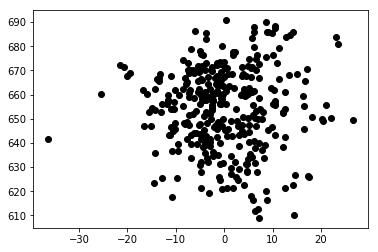

In [16]:
plt.scatter(sm_model.resid, sm_model.fittedvalues, color='black')
plt.show()

As we can see, all the residuals are spread out (though there is an outlier that may need to be removed from the data) and there is no shape to it - just a big blob. This is exactly what we'd want to see, so we're in the clear!

Now, finally, let's see how well this model will perform on new data, or in this case, our test data. I couldn't find a Statsmodels method for calculating the R Squared on predicted vs actual values, so I'm using the method from scikit-learn instead:

In [17]:
from sklearn.metrics import r2_score

X3_test = sm.add_constant(X_test_new)
sm_predictions = sm_model.predict(X3_test)
print('R Squared:', r2_score(y_test, sm_predictions.values))

R Squared: 0.783934448390442


The R Squared for the new data is only slightly less than we saw before at .78, so our model indeed does a decent job at prediction! Now let's look at what the predicted data actually looks like against the actual data, shown on the scatterplot below. While not a perfectly straight line, it's still a pretty strong linear relationship - which we would expect to see from having such a high R Squared!

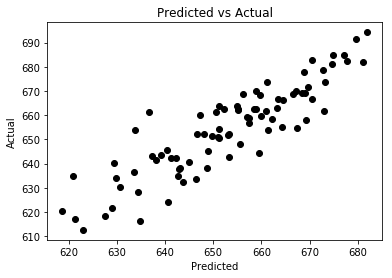

In [18]:
plt.scatter(sm_predictions,y_test,color='black')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

So we can conclude that principal component analysis and regression combined create a model that can predict test scores in California fairly well. At this point you could try adding back in the other categorical variables we dismissed earlier to see if that improves the R Squared even more - but that's beyond the scope of this analysis.

Now just for fun, let's see what it looks like using scikit-learn modules instead. You'll note that these are a lot simpler and easier to use than statsmodels - in fact, I first carried out this analysis using them, before realizing I wasn't able to perform the statistical analysis I wanted on the regression model (and also couldn't access certain features of the PCA model). We'll still use the same training and testing data, so we'll jump right into its PCA module:

In [19]:
from sklearn.decomposition import PCA as PCA_sk

pca2 = PCA_sk()
X_pca_df = pd.DataFrame(pca2.fit_transform(X_train),index=X_train.index).add_prefix('comp_')

You'll note here that I jumped straight into creating the dataframe out of the component scores (or the calculated values). One of the many ways it differs is that you have to explicitly call fit or transform (or fit_transform for both) to generate the model and then apply it to the data. Statsmodels does that for you, however scikit-learn has a built in method for the explained variance:

In [20]:
print(pca2.explained_variance_ratio_)

[0.72035959 0.17894202 0.07636007 0.02433832]


The formatting is a little different, but these numbers should look familiar - they should be nearly the same as those calculated from the statsmodels version, therefore the cumulative ratios should be similar as well. This module doesn't give us direct access to the eigenvectors or eigenvalues, which was a nice aspect of statsmodels' module. However scikit-learn makes the above calculations easy, as well as transforming new data easy, so it depends on what you're looking for. Speaking of, let's create our training and test data from the PCA. We will go ahead and use the same variables that we discovered were significant from our previous analysis.

In [21]:
X_train_sk = pd.concat([X_pca_df.iloc[:,0:2], grade_span.iloc[X_train.index]], axis=1)

X_test_sk = pd.DataFrame(pca2.transform(X_test), index=X_test.index).add_prefix('comp_').iloc[:,0:2]
X_test_sk =  pd.concat([X_test_sk, grade_span.iloc[X_test.index]], axis=1)

Now we can run scikit-learn's linear regression and evaluate its result using the R Squared metric:

In [22]:
from sklearn.linear_model import LinearRegression

LinReg = LinearRegression()
LinReg.fit(X_train_sk, y_train)
sk_predictions = LinReg.predict(X_test_sk)

print('R Squared:', r2_score(y_test, sk_predictions))

R Squared: 0.7839382514933328


The R Squared is .78, just like in the first model we created. So the major takeaway here is that both statsmodels and scikit-learn's PCA and linear regression modules produce similar results - as they should - but they offer different methods. Scikit-learn is more user friendly overall, however statsmodels gives you a lot more information, so which one you decide to use ultimately depends on your use case.

That's it for this analysis, I hope that was informative and useful! Please don't hesitate to reach out if you have any questions or feedback. Thanks so much for reading!